In [18]:
!pip install pandas scikit-learn requests matplotlib seaborn wordcloud

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
from google.colab import userdata

sns.set_style("whitegrid")

In [19]:
# --- Configuration Constants ---
MAL_CLIENT_ID = userdata.get('MAL_CLIENT_ID')
MAL_API_BASE_URL = userdata.get('MAL_API_BASE_URL')

# Exploratory Data Analysis (EDA)
Provide crucial insights into the distribution, relationships, and characteristics of the top 15,000 anime dataset.

**Loading and Initial Inspection**

First, we load the dataset and perform a high-level inspection.

In [20]:
# --- Step 1: Loading ---
df_anime = pd.read_csv('top_anime_dataset.csv')
print("Dataset loaded successfully!")
original_shape = df_anime.shape
print(f"Original dataset contained {original_shape[0]} entries.")

# --- Step 2: Early Filtering ---
# We remove any rows where the 'rating' is in the big no no.
df_anime = df_anime[df_anime['rating'] != 'Rx - Hentai']
df_anime = df_anime[df_anime['rating'] != 'R+ - Mild Nudity']
print(f"\nFiltered out 'Rx - Hentai'. The dataset now contains {df_anime.shape[0]} entries.")
print(f"{original_shape[0] - df_anime.shape[0]} entries were removed.")

# --- Step 3: Initial Inspection (on the filtered data) ---
# Display the first few rows to understand the structure
print("\nFirst 5 rows of the filtered dataset:")
display(df_anime.head())

# Get a concise summary of the dataframe, including data types and non-null values
print("\nFiltered Dataset Information (Data Types and Non-Null Counts):")
df_anime.info()

# Get a statistical summary of the numerical columns
print("\nStatistical Summary of Numerical Columns (Filtered):")
display(df_anime.describe())

Dataset loaded successfully!
Original dataset contained 15000 entries.

Filtered out 'Rx - Hentai'. The dataset now contains 12949 entries.
2051 entries were removed.

First 5 rows of the filtered dataset:


,anime_id,anime_url,image_url,name,english_name,japanese_names,score,genres,synopsis,type,...,producers,studios,source,duration,rating,rank,popularity,favorites,scored_by,members
0,52991,https://myanimelist.net/anime/52991/Sousou_no_...,https://cdn.myanimelist.net/images/anime/1015/...,Sousou no Frieren,Frieren: Beyond Journey's End,葬送のフリーレン,9.31,"Adventure, Drama, Fantasy",During their decade-long quest to defeat the D...,TV,...,"Aniplex, Dentsu, Shogakukan-Shueisha Productio...",Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,1.0,160,63200,603520,1035677
1,5114,https://myanimelist.net/anime/5114/Fullmetal_A...,https://cdn.myanimelist.net/images/anime/1208/...,Fullmetal Alchemist: Brotherhood,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,9.10,"Action, Adventure, Drama, Fantasy",After a horrific alchemy experiment goes wrong...,TV,...,"Aniplex, Square Enix, Mainichi Broadcasting Sy...",Bones,Manga,24 min per ep,R - 17+ (violence & profanity),2.0,3,231928,2196353,3483268
2,9253,https://myanimelist.net/anime/9253/Steins_Gate,https://cdn.myanimelist.net/images/anime/1935/...,Steins;Gate,Steins;Gate,STEINS;GATE,9.07,"Drama, Sci-Fi, Suspense",Eccentric scientist Rintarou Okabe has a never...,TV,...,"Frontier Works, Media Factory, Kadokawa Shoten...",White Fox,Visual novel,24 min per ep,PG-13 - Teens 13 or older,3.0,14,194507,1449844,2667979
3,60022,https://myanimelist.net/anime/60022/One_Piece_...,https://cdn.myanimelist.net/images/anime/1455/...,One Piece Fan Letter,NaN,ONE PIECE FAN LETTER,9.06,"Action, Adventure, Fantasy",Although the golden age of piracy is about to ...,TV Special,...,NaN,Toei Animation,Light novel,24 min,PG-13 - Teens 13 or older,4.0,2350,1970,68977,91278
4,38524,https://myanimelist.net/anime/38524/Shingeki_n...,https://cdn.myanimelist.net/images/anime/1517/...,Shingeki no Kyojin Season 3 Part 2,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,9.05,"Action, Drama, Suspense",Seeking to restore humanity's diminishing hope...,TV,...,"Production I.G, Dentsu, Mainichi Broadcasting ...",Wit Studio,Manga,23 min per ep,R - 17+ (violence & profanity),5.0,21,60500,1671010,2407861



Filtered Dataset Information (Data Types and Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
Index: 12949 entries, 0 to 14999
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   anime_id        12949 non-null  int64  
 1   anime_url       12949 non-null  object 
 2   image_url       12949 non-null  object 
 3   name            12949 non-null  object 
 4   english_name    7430 non-null   object 
 5   japanese_names  12905 non-null  object 
 6   score           12949 non-null  float64
 7   genres          11352 non-null  object 
 8   synopsis        12649 non-null  object 
 9   type            12948 non-null  object 
 10  episodes        12884 non-null  float64
 11  premiered       4425 non-null   object 
 12  producers       7935 non-null   object 
 13  studios         10646 non-null  object 
 14  source          12949 non-null  object 
 15  duration        12949 non-null  object 
 16  rating          1

,anime_id,score,episodes,rank,popularity,favorites,scored_by,members
count,12949.000000,12949.000000,12884.00000,11124.000000,12949.000000,12949.000000,1.294900e+04,1.294900e+04
mean,26880.966484,6.703193,13.90104,5904.076591,8702.934203,874.886246,3.818687e+04,7.450242e+04
std,19272.503879,0.718113,53.86609,3445.174898,5718.861661,6495.235950,1.388814e+05,2.309706e+05
min,1.000000,5.570000,1.00000,1.000000,1.000000,0.000000,1.020000e+02,1.800000e+02
25%,6809.000000,6.120000,1.00000,2900.500000,3650.000000,1.000000,4.250000e+02,1.304000e+03
50%,30749.000000,6.610000,3.00000,5872.500000,8191.000000,9.000000,2.249000e+03,6.190000e+03
75%,41487.000000,7.220000,13.00000,8890.000000,13270.000000,99.000000,1.690400e+04,4.218200e+04
max,60988.000000,9.310000,3057.00000,11923.000000,21856.000000,234344.000000,2.904954e+06,4.116124e+06


**1. Dataset Information and Missing Data:**

* **Completeness:** The dataset is now composed of 12,949 anime entries.
* **Significant Missing Data:** The counts for columns with missing values have been updated:
    * `premiered`: Remains the most incomplete field with only 4,425 non-null entries.
    * `english_name`: Has 7,430 non-null entries.
    * `producers`: Contains 7,935 non-null entries.
    * `studios`: Has 10,646 non-null entries.
    * `genres`: Contains 11,352 non-null entries.
    * `rank`: Now has 11,124 ranked entries.

**2. Statistical Summary of Numerical Columns:**

* **Score:** The average score is now approximately 6.70. The range remains from a minimum of 5.57 to a maximum of 9.31. 50% of the anime have a score of 6.61 or higher.
* **Episodes:** The mean number of episodes is 13.90, while the median is 3.00. The maximum number of episodes is still 3,057.
* **User Engagement Metrics (`favorites`, `scored_by`, `members`)**:
    * The `favorites` count ranges from 0 to 234,344, with a median of 9.00.
    * The number of members ranges up to 4,116,124.
    * The `scored_by` count has a mean of 3.82e+04.
    * The large standard deviations across these metrics continue to indicate that engagement is dominated by a few highly popular anime.

**Analysis of Categorical Features**

/tmp/ipython-input-21-1112894964.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_anime['type'], ax=axes[0], order=df_anime['type'].value_counts().index, palette='viridis')
/tmp/ipython-input-21-1112894964.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_anime['source'], ax=axes[1], order=df_anime['source'].value_counts().index, palette='plasma')
/tmp/ipython-input-21-1112894964.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_anime['rating'], ax=axes[2], order=df_anime['rating'].value_counts().index, palette=

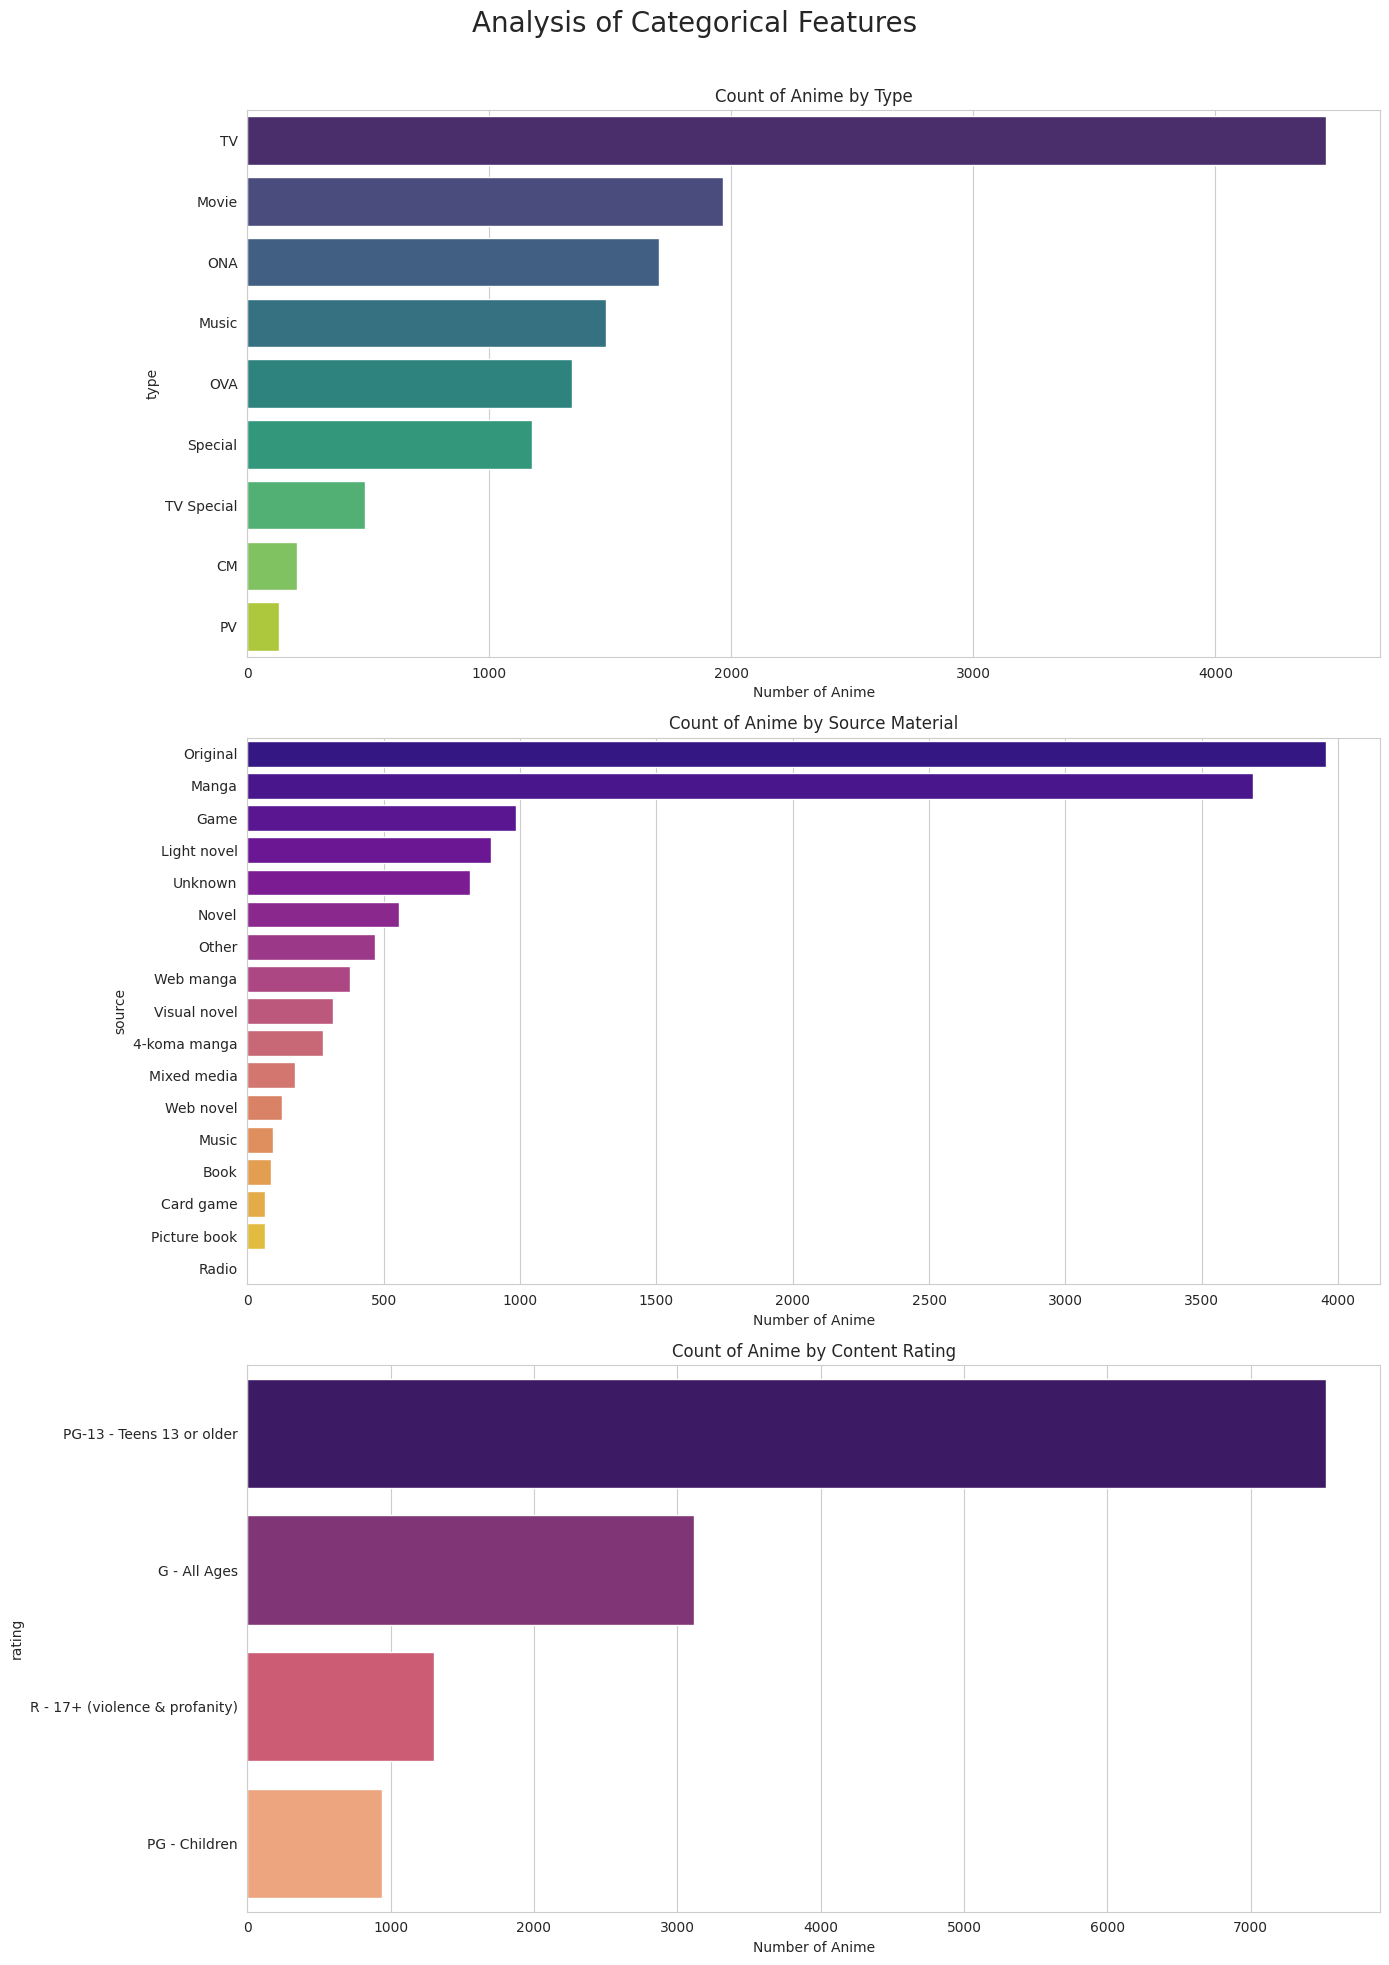

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(14, 20))
fig.suptitle('Analysis of Categorical Features', fontsize=20)

# Anime Type Count
sns.countplot(y=df_anime['type'], ax=axes[0], order=df_anime['type'].value_counts().index, palette='viridis')
axes[0].set_title('Count of Anime by Type')
axes[0].set_xlabel('Number of Anime')

# Anime Source Material Count
sns.countplot(y=df_anime['source'], ax=axes[1], order=df_anime['source'].value_counts().index, palette='plasma')
axes[1].set_title('Count of Anime by Source Material')
axes[1].set_xlabel('Number of Anime')

# Anime Content Rating Count
sns.countplot(y=df_anime['rating'], ax=axes[2], order=df_anime['rating'].value_counts().index, palette='magma')
axes[2].set_title('Count of Anime by Content Rating')
axes[2].set_xlabel('Number of Anime')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

**Top Genres, Studios, and Producers**

The `genres`, `studios`, and `producers` columns are comma-separated strings. We need to parse them to find the most frequent entries, which will give us insight into what content is most prevalent in our high-ranking dataset.

/tmp/ipython-input-22-410422203.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='item', data=df_counts, palette='coolwarm')


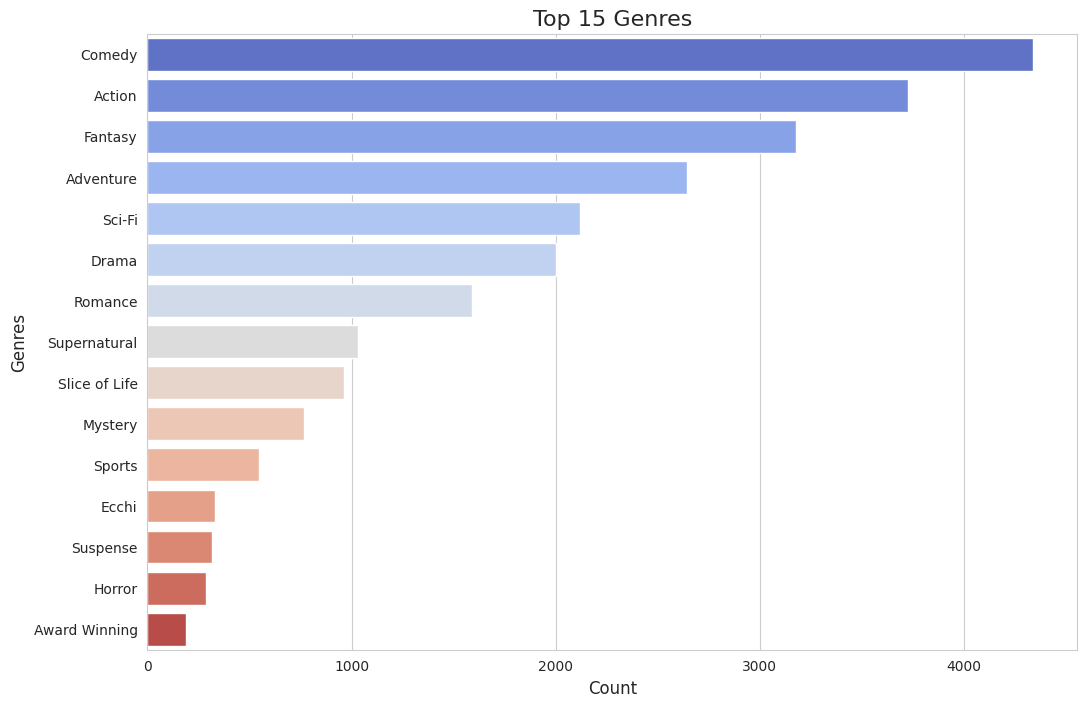

/tmp/ipython-input-22-410422203.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='item', data=df_counts, palette='coolwarm')


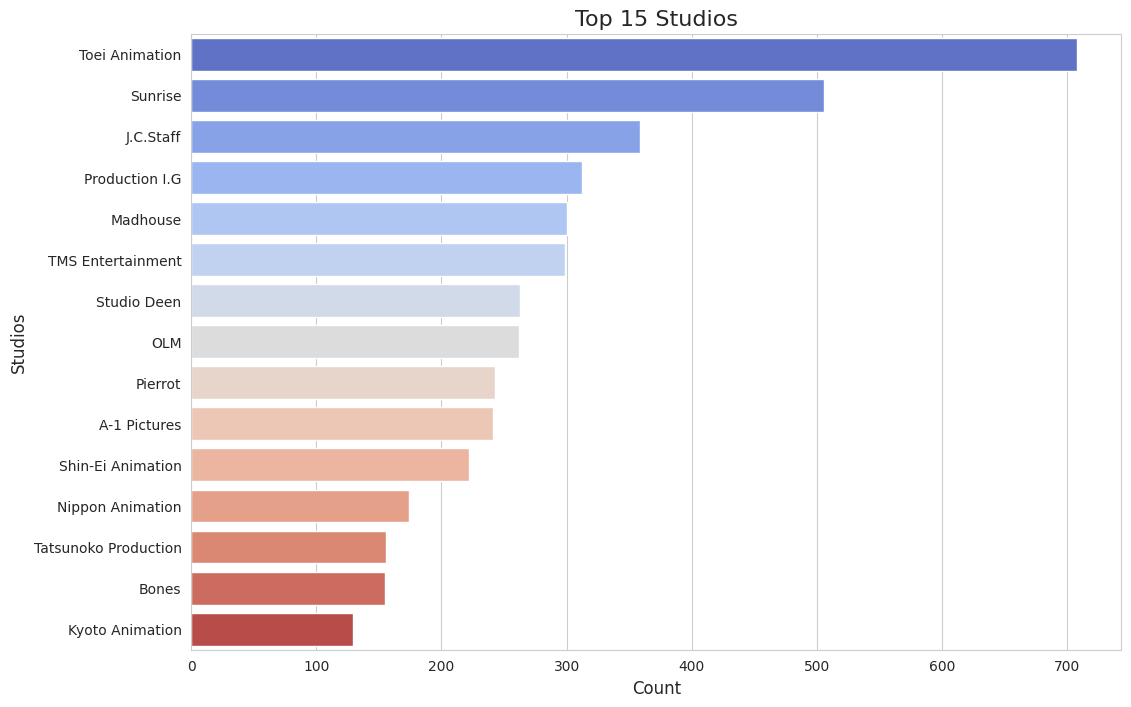

/tmp/ipython-input-22-410422203.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='item', data=df_counts, palette='coolwarm')


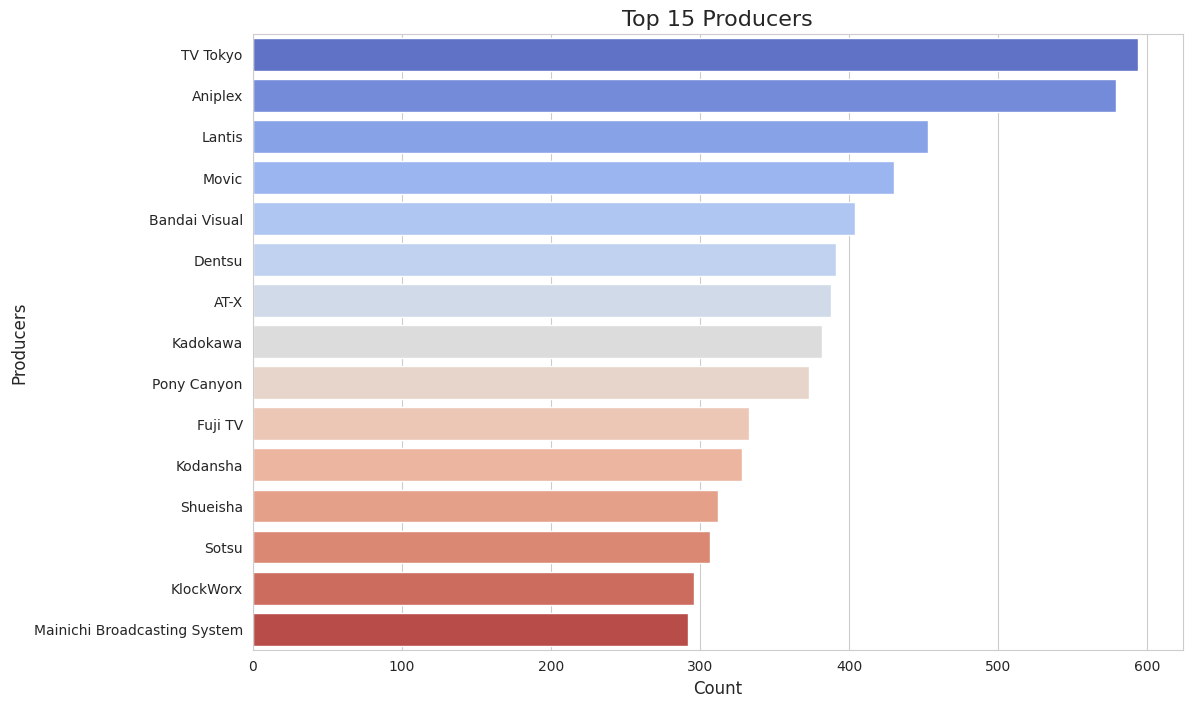

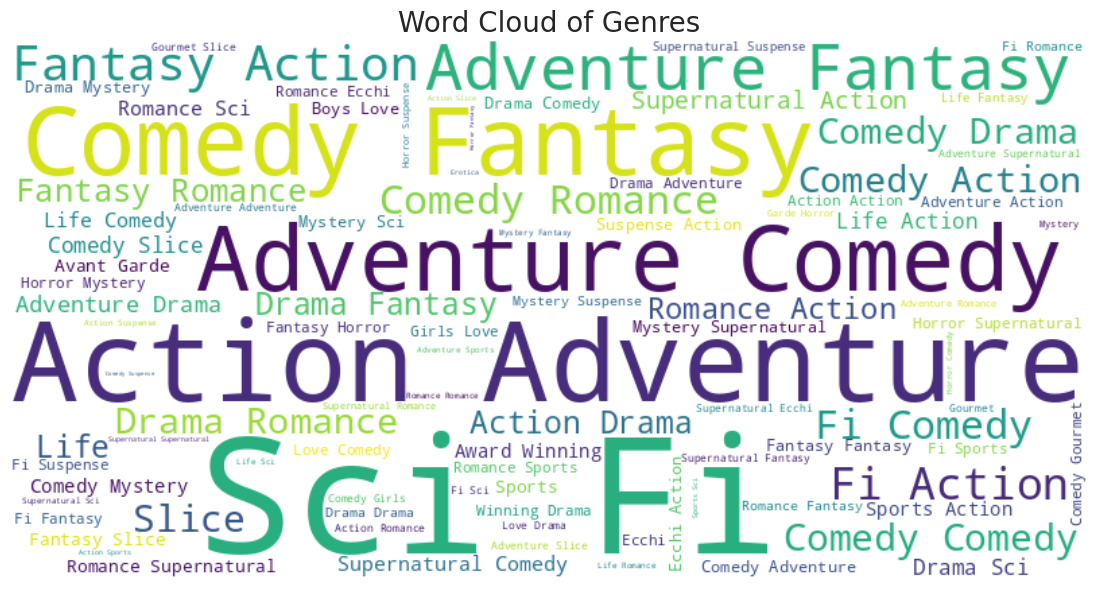

In [22]:
def plot_top_n_from_column(df, column_name, top_n=15):
    """Helper function to parse comma-separated strings and plot the top N items."""
    # Drop rows where the column is NaN
    df_filtered = df.dropna(subset=[column_name])
    # Split the strings and create a flat list
    items = df_filtered[column_name].str.split(',').sum()
    # Strip leading/trailing whitespace from each item
    items = [item.strip() for item in items]

    # Count the frequency of each item
    item_counts = Counter(items)

    # Create a DataFrame for plotting
    df_counts = pd.DataFrame(item_counts.most_common(top_n), columns=['item', 'count'])

    # Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='count', y='item', data=df_counts, palette='coolwarm')
    plt.title(f'Top {top_n} {column_name.capitalize()}', fontsize=16)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel(column_name.capitalize(), fontsize=12)
    plt.show()

if not df_anime.empty:
    plot_top_n_from_column(df_anime, 'genres')
    plot_top_n_from_column(df_anime, 'studios')
    plot_top_n_from_column(df_anime, 'producers')

# Genre Word Cloud for a more visual representation
if not df_anime.empty:
    all_genres = ' '.join(df_anime.dropna(subset=['genres'])['genres'])
    all_genres = all_genres.replace(',', ' ')

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_genres)

    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Genres', fontsize=20)
    plt.show()

**Insights:**

Genres: Action, Comedy, Fantasy, Sci-Fi, and Drama are the most dominant genres, showing their broad appeal.

Studios: Legacy studios and modern powerhouses are present, but many anime are produced by smaller, less frequent studios. Toei Animation and J.C.Staff appear frequently.

Producers: Toei Animation stands out as a major producer involved in a vast number of high-ranking anime, highlighting its significant influence in the industry.

**Correlation and Relationships**

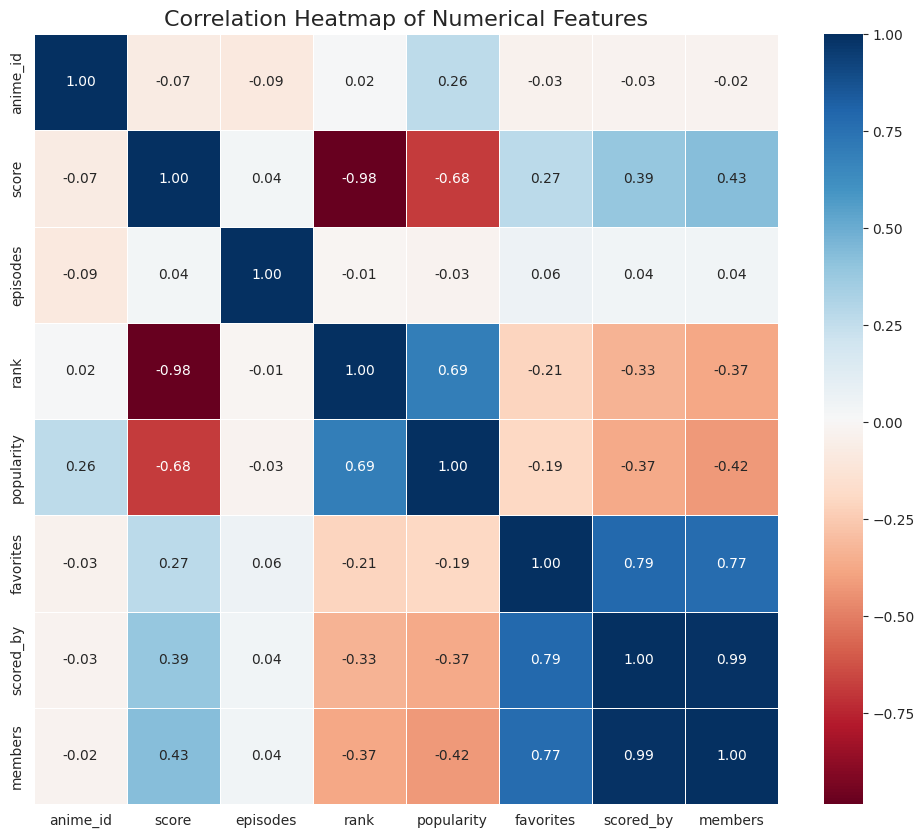

In [23]:
# Correlation Heatmap
plt.figure(figsize=(12, 10))
# Select only numerical columns for correlation
numerical_cols = df_anime.select_dtypes(include=np.number)
sns.heatmap(numerical_cols.corr(), annot=True, cmap='RdBu', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.show()

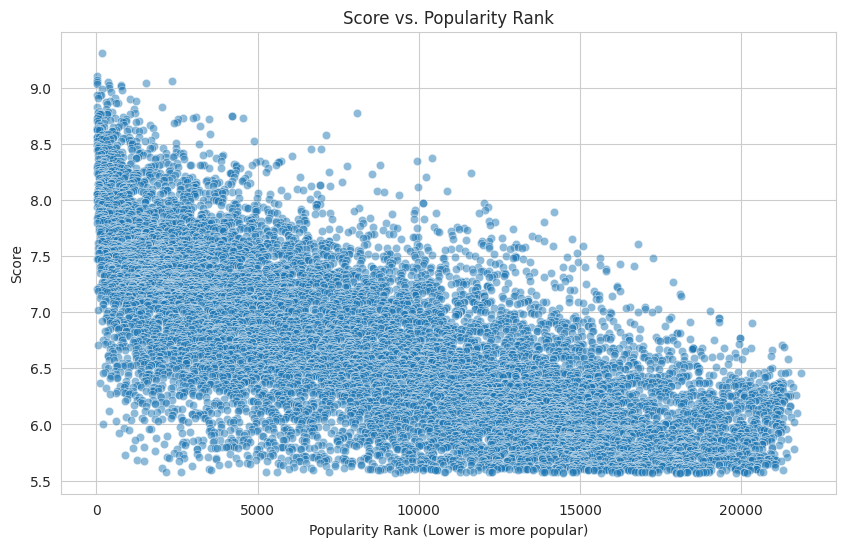

In [24]:
# Scatter plot of Score vs. Popularity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='popularity', y='score', data=df_anime, alpha=0.5)
plt.title('Score vs. Popularity Rank')
plt.xlabel('Popularity Rank (Lower is more popular)')
plt.ylabel('Score')
plt.show()

# Preprocessing and Feature Engineering

**Feature Engineering and Model Preparation**

In this crucial step, we will:
1.  **Apply our cleanup decisions** by dropping the correlated numerical columns.
2.  **Engineer a `content` feature** by combining the most important text-based columns (`genres`, `synopsis`, etc.). This single string will serve as a "document" representing each anime.
3.  **Vectorize this content** into a numerical matrix using TF-IDF. This matrix is the final, machine-readable knowledge base that our model will use to understand the relationships between anime.


---
Breakdown of which numerical variables we should eliminate and the reasoning behind each decision:

**Variables to Eliminate**

**1. `rank`**
* **Reasoning:** The heatmap shows an extremely strong negative correlation of **-0.98** between `rank` and `score`. This means they are nearly perfect inverses of each other; as the score goes up, the rank goes down. `rank` is a *derived metric*—it's calculated directly from the `score` relative to other anime. Including it would be redundant and adds no new information for the model that `score` doesn't already provide more granularly.
* **Verdict:** **Eliminate**.

**2. `scored_by`**
* **Reasoning:** This variable has a correlation of **0.99** with `members`. This is a near-perfect positive correlation, meaning the two columns contain almost the same information. It's logical to assume that the number of people who are members of an anime's page is almost identical to the number of people who have scored it. Keeping both would be highly redundant. We can keep `members` as it represents a slightly broader measure of community size.
* **Verdict:** **Eliminate**.

**3. `popularity`**
* **Reasoning:** `popularity` is another rank-based metric. It has a strong correlation with `rank` (0.69) and strong negative correlations with `members` (-0.42) and `scored_by` (-0.37). Since we are already keeping the raw count of `members` (which is a more direct measure of popularity than an ordinal rank), the `popularity` column becomes redundant. Using raw counts is generally better than using ranks, which can lose information.
* **Verdict:** **Strongly Consider Eliminating**. For our model, it's better to remove it.

**4. `anime_id`**
* **Reasoning:** While it has low correlation with other features, `anime_id` is an *identifier*, not a predictive feature. It holds no intrinsic value about the anime's content or quality. Including it as a feature would cause the model to treat it as noise or, even worse, to potentially overfit by memorizing specific IDs.
* **Verdict:** **Eliminate (from the feature set)**. It is essential to keep this column as the *index* of our dataframe for looking up anime, but it should not be used to train the model.

---

**Variables to Keep**

* **`score`**: This is arguably the most important feature for determining quality. We keep this as our primary quality metric.
* **`episodes`**: This has very low correlation with other numerical features, meaning it provides unique information that could be valuable (e.g., user preference for long vs. short series).
* **`members`**: We keep this as our primary measure of an anime's community size and overall reach.
* **`favorites`**: While it's correlated with `members` (0.77), it captures a different aspect of engagement—passionate, high-conviction interest rather than just broad membership. It's valuable enough to keep for now.

In [25]:
# --- Applying Column Selections ---
# Drop the columns identified during EDA to reduce multicollinearity.
# We will keep 'anime_id' for now as an identifier.
columns_to_drop = ['rank', 'scored_by', 'popularity']
df_processed = df_anime.drop(columns=columns_to_drop)
print(f"Dropped columns: {', '.join(columns_to_drop)}")

Dropped columns: rank, scored_by, popularity


In [26]:
# --- Feature Engineering (Creating the 'content' string - Updated) ---
desired_cols_updated = ['genres', 'synopsis', 'producers', 'studios', 'type', 'source', 'english_name']
found_cols_updated = []

# Loop through our desired columns and fill any empty (NaN) values with an empty string
for col in desired_cols_updated:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].fillna('')
        found_cols_updated.append(col)

# Create the 'content' string by combining the columns that were found.
# Replacing commas ensures words like 'Action,' and 'Action' are treated the same.
df_processed['content'] = df_processed[found_cols_updated].apply(lambda row: ' '.join(row.astype(str).str.replace(',', ' ')), axis=1)

print(f"Engineered 'content' feature using: {', '.join(found_cols_updated)}")

# --- Vectorization (TF-IDF) ---
# Increase max_features and add ngram_range
tfidf_updated = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1, 2))
tfidf_matrix_updated = tfidf_updated.fit_transform(df_processed['content'])

# Update the global tfidf_matrix variable with the new matrix
tfidf_matrix = tfidf_matrix_updated

Engineered 'content' feature using: genres, synopsis, producers, studios, type, source, english_name


In [27]:
# --- Index Mapping ---
# Create a mapping from anime_id to the dataframe index for fast lookups later.
indices = pd.Series(df_processed.index, index=df_processed['anime_id']).drop_duplicates()

print(f"✅ Knowledge Base successfully built.")
print(f"Vectorized {tfidf_matrix.shape[0]} anime entries into a matrix with {tfidf_matrix.shape[1]} features.")

✅ Knowledge Base successfully built.
Vectorized 12949 anime entries into a matrix with 10000 features.


#  Online Prediction: Generating Personalized Recommendations
This section contains all the functions needed to produce the final output. We will define functions to:
1.  **Fetch a user's anime list** from the official MAL API.
2.  **Create a "taste profile"** for that user based on their ratings.
3.  **Compare the profile** to our knowledge base and generate ranked recommendations.


In [28]:
def get_user_anime_list_official(username, client_id):
    """
    Fetches the full anime list for a given MAL user from the official v2 API.
    It handles pagination to retrieve all entries the user has rated.
    """
    url = f"{MAL_API_BASE_URL}/users/{username}/animelist"
    headers = {'X-MAL-CLIENT-ID': client_id}
    user_anime_list = []

    # API parameters: we request the list_status field to get scores and set a high limit.
    # 'nsfw=false' is included.
    params = {'fields': 'list_status', 'limit': 1000, 'nsfw': 'false'}

    print(f"Fetching anime list for user '{username}' from the official MAL API...")

    while url:
        try:
            response = requests.get(url, headers=headers, params=params)
            response.raise_for_status()  # Raises an error for bad status codes (4xx or 5xx)
            data = response.json()

            # Process each anime in the current page of results
            for item in data.get('data', []):
                list_status = item.get('list_status', {})
                # We only consider anime the user has actually scored
                if list_status.get('score', 0) > 0:
                    user_anime_list.append({
                        'mal_id': item.get('node', {}).get('id'),
                        'score': list_status.get('score')
                    })

            # Get the URL for the next page, or None if it's the last page
            url = data.get('paging', {}).get('next')
            params = {} # Subsequent requests using the 'next' URL don't need params

            if url:
                print(f"Fetching next page...")
                time.sleep(0.5) # Be respectful to the API by adding a small delay

        except requests.exceptions.HTTPError as e:
            print(f"Error fetching data: User '{username}' may not exist or has a private list. (HTTP {e.response.status_code})")
            return [] # Return an empty list on error
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
            return []

    print(f"Successfully fetched {len(user_anime_list)} scored anime for '{username}'.")
    return user_anime_list

In [29]:
def get_user_anime_list_official(username, client_id):
    """
    Fetches the full anime list for a given MAL user from the official v2 API.
    It handles pagination to retrieve all entries the user has rated.
    """
    url = f"{MAL_API_BASE_URL}/users/{username}/animelist"
    headers = {'X-MAL-CLIENT-ID': client_id}
    user_anime_list = []

    # API parameters: we request the list_status field to get scores and set a high limit.
    params = {'fields': 'list_status', 'limit': 1000, 'nsfw': 'false'}

    print(f"Fetching anime list for user '{username}' from the official MAL API...")

    while url:
        try:
            response = requests.get(url, headers=headers, params=params)
            response.raise_for_status()  # Raises an error for bad status codes (4xx or 5xx)
            data = response.json()

            # Process each anime in the current page of results
            for item in data.get('data', []):
                list_status = item.get('list_status', {})
                # We only consider anime the user has actually scored
                if list_status.get('score', 0) > 0:
                    user_anime_list.append({
                        'mal_id': item.get('node', {}).get('id'),
                        'score': list_status.get('score')
                    })

            # Get the URL for the next page, or None if it's the last page
            url = data.get('paging', {}).get('next')
            params = {} # Subsequent requests using the 'next' URL don't need params

            if url:
                print(f"Fetching next page...")
                time.sleep(0.5) # Be respectful to the API by adding a small delay

        except requests.exceptions.HTTPError as e:
            print(f"Error fetching data: User '{username}' may not exist or has a private list. (HTTP {e.response.status_code})")
            return [] # Return an empty list on error
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
            return []

    print(f"Successfully fetched {len(user_anime_list)} scored anime for '{username}'.")
    return user_anime_list

In [30]:
def create_user_profile(user_anime_list, tfidf_matrix, indices, df_processed):
    """
    Creates a user's 'taste profile' vector.
    This is a weighted average of the TF-IDF vectors of anime they have rated,
    weighted by both score and the number of members for the anime.
    Includes a simple penalty for low scores.
    """
    # Filter the user's list to only include anime that exist in our knowledge base
    valid_user_anime = [item for item in user_anime_list if item['mal_id'] in indices]
    if not valid_user_anime:
        return None, set()

    # Get the set of anime IDs the user has already seen to filter them out later
    watched_anime_ids = {item['mal_id'] for item in valid_user_anime}

    # Create a vector initialized to zeros that matches the width of our TF-IDF matrix
    profile_vector = np.zeros(tfidf_matrix.shape[1])

    # Calculate the weighted sum of vectors
    total_weight = 0
    for item in valid_user_anime:
        mal_id = item['mal_id']
        user_score = item['score']
        idx = indices[mal_id]

        # Get the number of members for this anime from the processed dataframe
        members_count = df_processed[df_processed['anime_id'] == mal_id]['members'].iloc[0]

        # Calculate weight: Score * log(members_count + 1) to dampen the effect of extremely popular anime
        # Adding 1 to members_count to avoid log(0)
        weight = user_score * np.log1p(members_count)

        # Simple penalty for low scores (e.g., scores 1-5)
        if user_score <= 5:
            weight *= -0.5 # Assign a negative weight to low scores (adjust the multiplier as needed)

        # Convert the sparse matrix row to a dense numpy array before multiplication
        profile_vector += tfidf_matrix[idx].toarray().flatten() * weight
        total_weight += abs(weight) # Sum absolute weights for normalization

    # Normalize the profile vector
    if total_weight > 0:
        profile_vector /= total_weight
    else:
        return None, set() # Handle case where all weights are zero (unlikely but possible)

    return profile_vector, watched_anime_ids

In [31]:
def generate_recommendations(username, client_id, df_processed):
    """
    The main orchestrator function. It takes a username and returns a list of
    recommended anime IDs, now with a numerical feature re-ranking step.
    """
    # 1. Fetch user's live data from the MAL API
    user_list = get_user_anime_list_official(username, client_id)
    if not user_list:
        return f"Could not generate recommendations for '{username}'."

    # 2. Build the user's unique taste profile
    user_profile, watched_ids = create_user_profile(user_list, tfidf_matrix, indices, df_processed)
    if user_profile is None:
        return "Could not create a taste profile. The user may have only watched anime not present in our knowledge base or all weights were zero."

    # 3. Calculate Cosine Similarity
    cosine_similarities = cosine_similarity(user_profile.reshape(1, -1), tfidf_matrix)

    # Get a list of (index, similarity_score) pairs
    sim_scores = list(enumerate(cosine_similarities[0]))

    # --- 4. Filter and Prepare for Numerical Re-ranking ---
    # Create a temporary list of potential recommendations including original index and similarity
    potential_recommendations = []
    for i, score in sim_scores:
        anime_id = df_processed['anime_id'].iloc[i]
        # Only consider anime the user hasn't seen
        if anime_id not in watched_ids:
            potential_recommendations.append({'index': i, 'anime_id': anime_id, 'similarity': score})

    # If no potential recommendations are found after filtering, return empty list
    if not potential_recommendations:
        return [], user_list # Return an empty list if no recommendations found

    # --- 5. Retrieve Numerical Features for Potential Recommendations ---
    # Get the original indices of the potential recommendations
    potential_indices = [rec['index'] for rec in potential_recommendations]

    # Extract numerical features from the processed dataframe based on these indices
    numerical_features_df = df_processed.iloc[potential_indices][['anime_id', 'score', 'members']].copy()

    # Merge the similarity scores with the numerical features
    recs_with_features = pd.merge(
        pd.DataFrame(potential_recommendations),
        numerical_features_df,
        on='anime_id'
    )

    # --- 6. Apply Numerical Re-ranking ---
    # We'll combine similarity score with overall score and members count.
    recs_with_features['rerank_score'] = (
        recs_with_features['similarity'] *
        (recs_with_features['score'] + 1) * # Add 1 to score to avoid multiplying by 0
        np.log1p(recs_with_features['members']) # Use log1p for members count
    )

    # Sort by the new re-ranking score in descending order
    recs_with_features = recs_with_features.sort_values(by='rerank_score', ascending=False)

    # --- 7. Select and Return Top Recommendations ---
    # Get the top N anime IDs after re-ranking (n=50 for now)
    top_n_recommendations = recs_with_features['anime_id'].head(50).tolist()

    return top_n_recommendations, user_list

In [33]:
user_to_recommend = "sentric83"

# Capture the recs_with_features DataFrame returned by the function
top_50_recommendations, user_list_for_formatting = generate_recommendations(user_to_recommend, MAL_CLIENT_ID, df_processed)

# Check if the first return value is the error message string or a list of recommendations
if isinstance(top_50_recommendations, list):
    print(f"\n✅ Recommended Anime IDs for user '{user_to_recommend}':")
    # Print in a more readable format, 10 IDs per line
    for i in range(0, len(top_50_recommendations), 10):
        print("  ".join(map(str, top_50_recommendations[i:i+10])))
    # You might also want to check if recs_with_features is not None before proceeding
    # with the visualization plot in the next cell.
else:
    # If the first return value was an error message, print it.
    print(f"\n❌ {top_50_recommendations}")

Fetching anime list for user 'sentric83' from the official MAL API...
Successfully fetched 133 scored anime for 'sentric83'.

✅ Recommended Anime IDs for user 'sentric83':
28891  45576  39587  32935  30230  40776  245  6547  30831  49387
22135  11741  40028  35557  46102  42203  55888  44511  13125  2904
37521  14713  37822  31240  32937  47194  23273  33486  38524  38003
17895  50631  18115  31043  7785  54789  16498  31859  40935  35247
28297  12365  11843  42938  2001  51179  19363  48926  54856  2236


# Comparison: User's Top Anime vs. Recommendations

In [34]:
from IPython.display import display, HTML

# --- 1. Process User's Top-Rated Anime ---

# Sort the user's list by their score in descending order and take the top 5
user_list_sorted = sorted(user_list_for_formatting, key=lambda x: x['score'], reverse=True)[:5]

# Get the anime IDs and create a dataframe for their scores
user_top_ids = [item['mal_id'] for item in user_list_sorted]
user_scores_df = pd.DataFrame(user_list_sorted)

# Look up the anime details from our main dataframe
user_top_df = df_processed[df_processed['anime_id'].isin(user_top_ids)].copy()

# Merge to correctly associate the user's score with the anime details
user_top_df = pd.merge(user_top_df, user_scores_df, left_on='anime_id', right_on='mal_id')

# Select and rename columns for a clean display
user_top_df_display = user_top_df[['name', 'score_y']].rename(columns={'name': 'Anime Name', 'score_y': "User's Score"})

# Sort by the user's score for final display
user_top_df_display = user_top_df_display.sort_values(by="User's Score", ascending=False).reset_index(drop=True)
user_top_df_display.index += 1 # Start rank from 1

# Display the user's table
display(HTML("<h2>Top 5 Anime in List (by score)</h2>"))
display(user_top_df_display)

# --- 2. Process Top Recommended Anime ---

# Get the top 5 IDs from our recommendation list
top_5_recs_ids = top_50_recommendations[:200]

# Look up the anime details from our main dataframe
recs_top_df = df_processed[df_processed['anime_id'].isin(top_5_recs_ids)]

# Preserve the recommendation order, which might be lost after filtering
recs_top_df = recs_top_df.set_index('anime_id').loc[top_5_recs_ids].reset_index()

# Select and rename columns for a clean display
recs_top_df_display = recs_top_df[['name', 'score']].rename(columns={'name': 'Anime Name', 'score': 'Overall Score'})

# Sort by the overall score for final display in descending order
recs_top_df_display = recs_top_df_display.sort_values(by='Overall Score', ascending=False).reset_index(drop=True)
recs_top_df_display.index += 1 # Start rank from 1


# Display the recommendations table
display(HTML("<h2>Top 50 Recommended Anime</h2>"))
display(recs_top_df_display)

,Anime Name,User's Score
1,Fullmetal Alchemist: Brotherhood,10
2,Bleach: Sennen Kessen-hen,10
3,One Piece,10
4,Josee to Tora to Sakana-tachi,10
5,Horimiya,10


,Anime Name,Overall Score
1,Shingeki no Kyojin Season 3 Part 2,9.05
2,Fruits Basket: The Final,8.96
3,Code Geass: Hangyaku no Lelouch R2,8.91
4,Owarimonogatari 2nd Season,8.86
5,Vinland Saga Season 2,8.81
6,Shingeki no Kyojin: The Final Season,8.78
7,Haikyuu!! Karasuno Koukou vs. Shiratorizawa Ga...,8.77
8,Vinland Saga,8.76
9,Great Teacher Onizuka,8.68
10,Odd Taxi,8.65
